# Выпускная квалификационная работа - 3 Линейная Регрессия

* Провести предобработку данных (нормализацию)
* Обучить нескольких моделей для прогноза:
1. модуля упругости при растяжении
2. прочности при растяжении
* При построении модели необходимо 30% данных оставить на тестирование модели, на остальных происходит обучение моделей.
* При построении моделей провести поиск гиперпараметров модели с помощью поиска
по сетке с перекрестной проверкой, количество блоков равно 10.

In [199]:
import warnings; warnings.filterwarnings('ignore')
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-whitegrid')
sns.set_style("whitegrid")

In [200]:
import sklearn
from sklearn import linear_model
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDRegressor, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error, mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score, RandomizedSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn import preprocessing
from sklearn.preprocessing import Normalizer, LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import cross_val_score, cross_validate

from sklearn import metrics
import pickle
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import PolynomialFeatures

In [201]:
from scipy import stats
from scipy.stats import shapiro, kstest, boxcox
import statsmodels.api as sm

## Загрузка данных

In [202]:
df_outliers_cleaned = pd.read_excel('data/data_outliers_cleaned.xlsx', index_col=0)
df_outliers_cleaned.head(5)

,Соотношение матрица-наполнитель,"Плотность, кг/м3","модуль упругости, ГПа","Количество отвердителя, м.%","Содержание эпоксидных групп,%_2","Температура вспышки, С_2","Поверхностная плотность, г/м2","Модуль упругости при растяжении, ГПа","Прочность при растяжении, МПа","Потребление смолы, г/м2","Угол нашивки, град",Шаг нашивки,Плотность нашивки
0,1.857143,2030.0,738.736842,50.00,23.750000,284.615385,210.0,70.0,3000.0,220.0,0,4.0,60.0
1,1.857143,2030.0,738.736842,129.00,21.250000,300.000000,210.0,70.0,3000.0,220.0,0,5.0,47.0
2,2.771331,2030.0,753.000000,111.86,22.267857,284.615385,210.0,70.0,3000.0,220.0,0,5.0,57.0
3,2.767918,2000.0,748.000000,111.86,22.267857,284.615385,210.0,70.0,3000.0,220.0,0,5.0,60.0
4,2.569620,1910.0,807.000000,111.86,22.267857,284.615385,210.0,70.0,3000.0,220.0,0,5.0,70.0


In [203]:
df_outliers_cleaned.describe()

,Соотношение матрица-наполнитель,"Плотность, кг/м3","модуль упругости, ГПа","Количество отвердителя, м.%","Содержание эпоксидных групп,%_2","Температура вспышки, С_2","Поверхностная плотность, г/м2","Модуль упругости при растяжении, ГПа","Прочность при растяжении, МПа","Потребление смолы, г/м2","Угол нашивки, град",Шаг нашивки,Плотность нашивки
count,936.000000,936.000000,936.000000,936.000000,936.000000,936.000000,936.000000,936.000000,936.000000,936.000000,936.000000,936.000000,936.000000
mean,2.925683,1974.040023,738.247627,110.916216,22.209030,286.040414,482.993901,73.305127,2467.488822,217.613374,46.057692,6.915585,57.451895
std,0.893712,70.808120,328.708665,27.037891,2.394871,39.400677,280.190377,3.037381,463.838911,57.827255,45.011619,2.509672,11.239331
min,0.547391,1784.482245,2.436909,38.668500,15.695894,179.374391,0.603740,65.553336,1250.392802,63.685698,0.000000,0.037639,27.272928
25%,2.321931,1923.443748,498.577158,92.523816,20.571516,259.184486,266.004099,71.248823,2146.936034,179.489091,0.000000,5.134988,50.209656
50%,2.904731,1977.258043,738.736842,111.113175,22.184713,286.024118,457.732246,73.259230,2457.959767,218.388715,90.000000,6.943337,57.584225
75%,3.546650,2020.158764,958.418993,130.001450,23.961818,312.991425,695.900862,75.310788,2755.169485,256.396777,90.000000,8.591450,64.798211
max,5.314144,2161.565216,1649.415706,181.828448,28.955094,386.067992,1291.340115,81.417126,3705.672523,359.052220,90.000000,13.732404,86.012427


In [204]:
df_outliers_cleaned.shape

(936, 13)

In [205]:
# Обучить нескольких моделей для прогноза модуля упругости при растяжении

In [206]:
# некоторые признаки имеют Высокий Коэффициент асимметрии (skew)
# например признак Поверхностная плотность, г/м2  (0.357603) Данные распределены  асимметрично 
# Неформально говоря, коэффициент асимметрии положителен, если правый хвост распределения длиннее левого, и отрицателен в противном случае.
#  Если распределение симметрично относительно математического ожидания, то его коэффициент асимметрии равен нулю
df_outliers_cleaned.skew()

Соотношение матрица-наполнитель         0.058917
Плотность, кг/м3                        0.002822
модуль упругости, ГПа                   0.083489
Количество отвердителя, м.%            -0.120959
Содержание эпоксидных групп,%_2         0.027075
Температура вспышки, С_2                0.007521
Поверхностная плотность, г/м2           0.357603
Модуль упругости при растяжении, ГПа    0.113901
Прочность при растяжении, МПа           0.106828
Потребление смолы, г/м2                -0.037592
Угол нашивки, град                     -0.047097
Шаг нашивки                             0.051818
Плотность нашивки                      -0.079965
dtype: float64

In [207]:
# Устранение проблем с асимметричным распределением данных
# Поверхностная плотность, г/м2           0.357603 (было)
# Поверхностная плотность, г/м2          -0.151796 (стало)
pd.DataFrame(PowerTransformer(method='yeo-johnson', standardize=True).fit_transform(df_outliers_cleaned), columns=df_outliers_cleaned.columns).skew()

Соотношение матрица-наполнитель        -0.020889
Плотность, кг/м3                       -0.002556
модуль упругости, ГПа                  -0.112879
Количество отвердителя, м.%            -0.034221
Содержание эпоксидных групп,%_2        -0.009802
Температура вспышки, С_2               -0.013505
Поверхностная плотность, г/м2          -0.151796
Модуль упругости при растяжении, ГПа    0.000399
Прочность при растяжении, МПа          -0.008029
Потребление смолы, г/м2                -0.039161
Угол нашивки, град                     -0.047097
Шаг нашивки                            -0.015111
Плотность нашивки                      -0.016179
dtype: float64

In [208]:
target_var_1 = df_outliers_cleaned['Модуль упругости при растяжении, ГПа']
train_vars_1 = df_outliers_cleaned.loc[:, df_outliers_cleaned.columns != 'Модуль упругости при растяжении, ГПа']

# Разбиваем выборки на обучающую 70% и тестовую 30%
Xtrain, X_test, ytrain, y_test = train_test_split(train_vars_1, target_var_1, test_size=0.3, random_state=0)

Xtrain.shape, X_test.shape

((655, 12), (281, 12))

In [209]:
# Проверка правильности разбивки 
df_outliers_cleaned.shape[0] - Xtrain.shape[0] - X_test.shape[0]

0

In [210]:
# датафрейм названия моделей и их ошибки
df_errors = pd.DataFrame(columns=['target_var','model_name','MSE', 'R2'])

# функция для визуализации факт-прогноз результатов моделей

def actual_and_predicted_plot(orig, predict, var, model_name):    
    plt.figure(figsize=(17,5))
    plt.title(f'Тестовые и прогнозные значения: {model_name}')
    plt.plot(orig, label='Тест')
    plt.plot(predict, label='Прогноз')
    plt.legend(loc='best')
    plt.ylabel(var)
    plt.xlabel('Количество наблюдений')
    plt.show()

In [211]:
# Преобразуем данные ближе к распределению Гаусса 
# Преобразование Йео-Джонсона (yeo-johnson) можно применять как к положительным,
# так и к отрицательным значениям переменной.
# RobustScaler   (value-median)/IQR

trans_pipe = make_pipeline(PowerTransformer(method='yeo-johnson', standardize=True), RobustScaler())

preproc = ColumnTransformer(
    transformers=[
        ('all_column', trans_pipe, Xtrain.columns)
    ]
)

model = LinearRegression()

linear_reg_1 = Pipeline(steps=[
    ('preproc', preproc),
    ('model', model)
], verbose=True)

linear_reg_1.fit(Xtrain, ytrain)
prediction_y_test_linear_1 = linear_reg_1.predict(X_test)

MSE_1 = mean_squared_error(y_test, prediction_y_test_linear_1)
MAE_1 = mean_absolute_error(y_test, prediction_y_test_linear_1)
R2_1 = r2_score(y_test, prediction_y_test_linear_1)

linear_errors1 = pd.DataFrame({'model_name':'LinearRegression_1', 'target_var':['Модуль упругости при растяжении, ГПа'], \
    'MSE':[MSE_1],   'R2':[R2_1]} )

# mean_absolute_error(y_1_test, prediction_y_test_linear_1), r2_score(y_1_test, prediction_y_test_linear_1), MSE_1, R2_1
# linear_errors1
df_errors = pd.concat([df_errors, linear_errors1], ignore_index=True)
df_errors


[Pipeline] ........... (step 1 of 2) Processing preproc, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.0s


,target_var,model_name,MSE,R2
0,"Модуль упругости при растяжении, ГПа",LinearRegression_1,7.920709,-0.021947


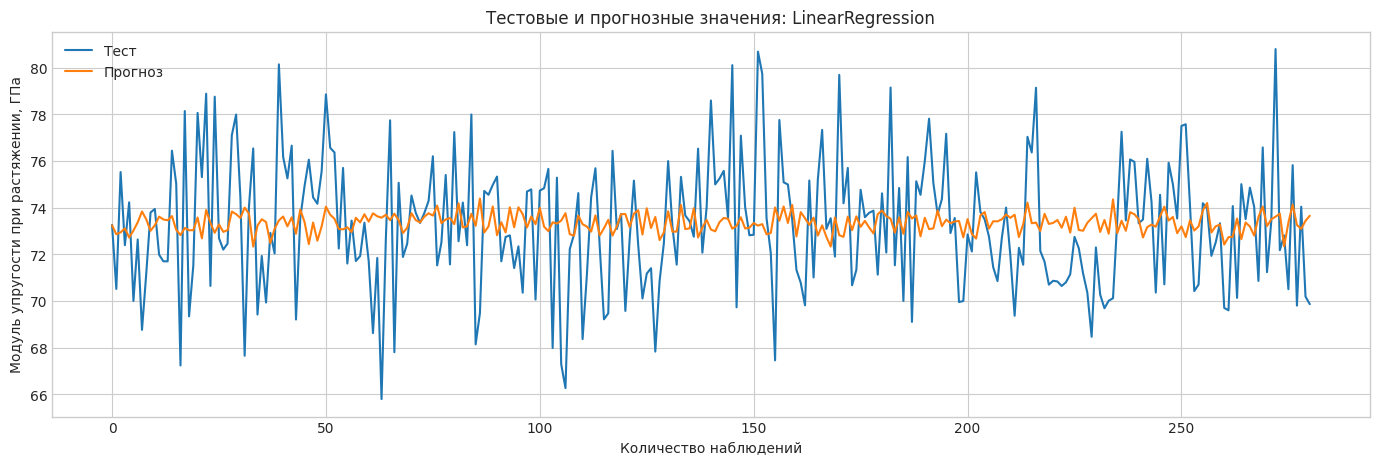

In [212]:
actual_and_predicted_plot(y_test.values, prediction_y_test_linear_1, 'Модуль упругости при растяжении, ГПа', 'LinearRegression')

In [213]:
pickle.dump(linear_reg_1, open('model/linear_reg_1.pkl', 'wb'))

In [214]:
# # load test
# linear_reg_1_load = pickle.load(open('model/linear_reg_1.pkl', 'rb'))
# mean_absolute_error(y_1_test, linear_reg_1_load.predict(X_1_test_raw))

#### Регрессия k-ближайших соседей

In [215]:
neigh = KNeighborsRegressor()
neigh_params = {'n_neighbors' : range(1, 101, 1), 
          'weights' : ['uniform', 'distance'],
          'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute']
          }

gs_cv10_neigh_1 = GridSearchCV(neigh, neigh_params, n_jobs=-1, cv=10)
gs_cv10_neigh_1.fit(Xtrain, ytrain)
# GSCV_neigh_1.best_params_
neigh_1 = gs_cv10_neigh_1.best_estimator_

MSE_1 = mean_squared_error(y_test, neigh_1.predict(X_test))
R2_1 = r2_score(y_test, neigh_1.predict(X_test))


neigh_errors = pd.DataFrame({'model_name':'KNeighborsRegressor_1', 'target_var':['Модуль упругости при растяжении, ГПа'],
    'MSE':[MSE_1], 'R2':[R2_1]})

df_errors = pd.concat([df_errors, neigh_errors], ignore_index=True)
df_errors

,target_var,model_name,MSE,R2
0,"Модуль упругости при растяжении, ГПа",LinearRegression_1,7.920709,-0.021947
1,"Модуль упругости при растяжении, ГПа",KNeighborsRegressor_1,7.797827,-0.006093


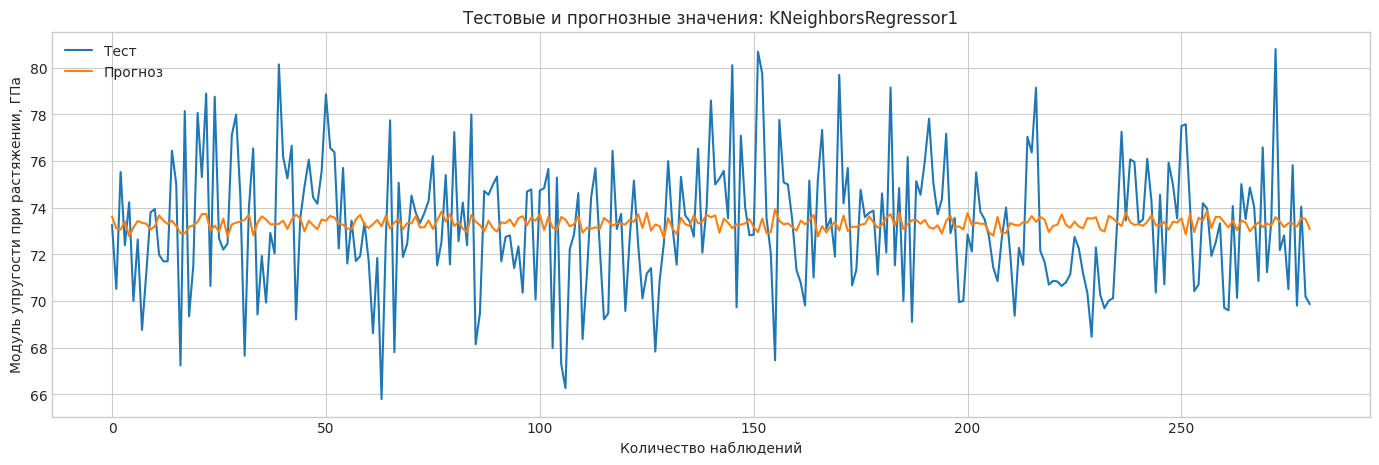

In [216]:
actual_and_predicted_plot(y_test.values, neigh_1.predict(X_test), 'Модуль упругости при растяжении, ГПа', 'KNeighborsRegressor1')

#### Регрессия , Случайный лес, гиперпараметры по умолчанию 

In [217]:

model = RandomForestRegressor(random_state=0)

rf_reg_1 = Pipeline(steps=[
    ('model', model)
], verbose=True)

rf_reg_1.fit(Xtrain, ytrain)
prediction_y_test_rf_reg_1 = rf_reg_1.predict(X_test)

MSE_1 =  mean_squared_error(y_test, prediction_y_test_rf_reg_1)
MAE_1 = mean_absolute_error(y_test, prediction_y_test_rf_reg_1)
R2_1 =             r2_score(y_test, prediction_y_test_rf_reg_1)

linear_errors1 = pd.DataFrame({'model_name':'RandomForestRegressor_1', 'target_var':['Модуль упругости при растяжении, ГПа'],  'MSE':[MSE_1],   'R2':[R2_1]} )

df_errors = pd.concat([df_errors, linear_errors1], ignore_index=True)
df_errors


[Pipeline] ............. (step 1 of 1) Processing model, total=   0.5s


,target_var,model_name,MSE,R2
0,"Модуль упругости при растяжении, ГПа",LinearRegression_1,7.920709,-0.021947
1,"Модуль упругости при растяжении, ГПа",KNeighborsRegressor_1,7.797827,-0.006093
2,"Модуль упругости при растяжении, ГПа",RandomForestRegressor_1,8.114218,-0.046914


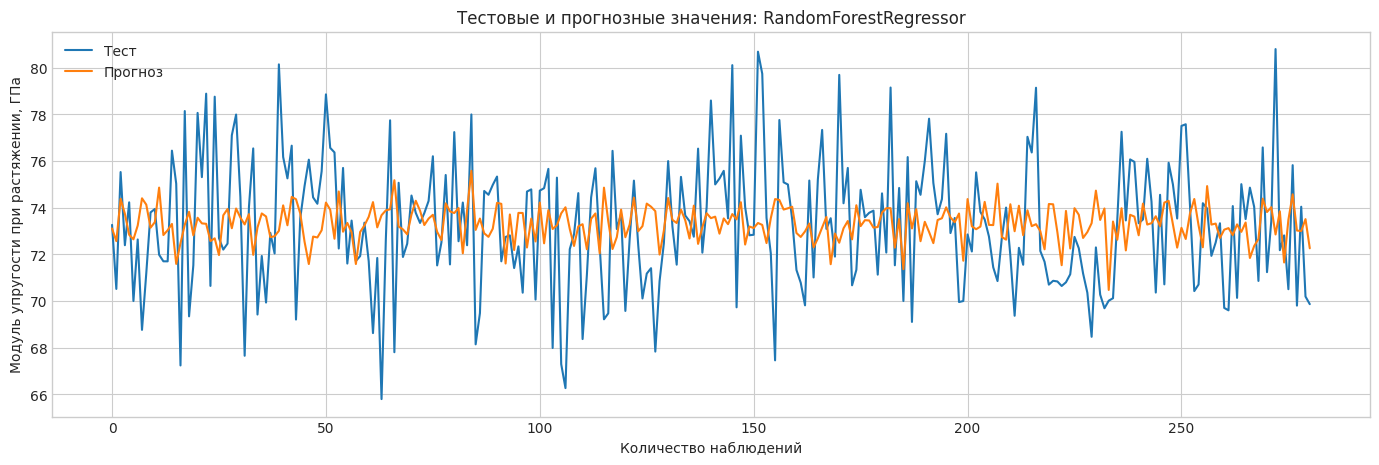

In [218]:
actual_and_predicted_plot(y_test.values, rf_reg_1.predict(X_test), 'Модуль упругости при растяжении, ГПа', 'RandomForestRegressor')

#### Регрессия Случайный лес поиск гиперпараметров по сетке с перекрестной проверкой, количество блоков равно 10 

In [219]:
# %%time
regr_rf_gs = RandomForestRegressor(random_state=0)

regr_rf_params = {
    'n_estimators' : range(1, 50, 10),
    'max_features': ['sqrt', 'log2'],
    'max_depth' : range(1, 5, 1),
    'criterion':['squared_error']
}

GScv10_regr_rf_1 = RandomizedSearchCV(regr_rf_gs, regr_rf_params, cv=10, verbose=1)
GScv10_regr_rf_1.fit(Xtrain, ytrain)
# print(GScv10_regr_rf_1.best_params_)
regr_rf_1 = GScv10_regr_rf_1.best_estimator_

MSE_1 = mean_squared_error(y_test, regr_rf_1.predict(X_test))
R2_1 = r2_score(y_test, regr_rf_1.predict(X_test))

rf1_errors = pd.DataFrame({'model_name':'RandomForestRegressor_1_grid_search', 'target_var':['Модуль упругости при растяжении, ГПа'], 
    'MSE':[MSE_1, ], 'R2':[R2_1, ]})

df_errors = pd.concat([df_errors, rf1_errors], ignore_index=True)
df_errors

Fitting 10 folds for each of 10 candidates, totalling 100 fits


,target_var,model_name,MSE,R2
0,"Модуль упругости при растяжении, ГПа",LinearRegression_1,7.920709,-0.021947
1,"Модуль упругости при растяжении, ГПа",KNeighborsRegressor_1,7.797827,-0.006093
2,"Модуль упругости при растяжении, ГПа",RandomForestRegressor_1,8.114218,-0.046914
3,"Модуль упругости при растяжении, ГПа",RandomForestRegressor_1_grid_search,7.750835,-0.000030


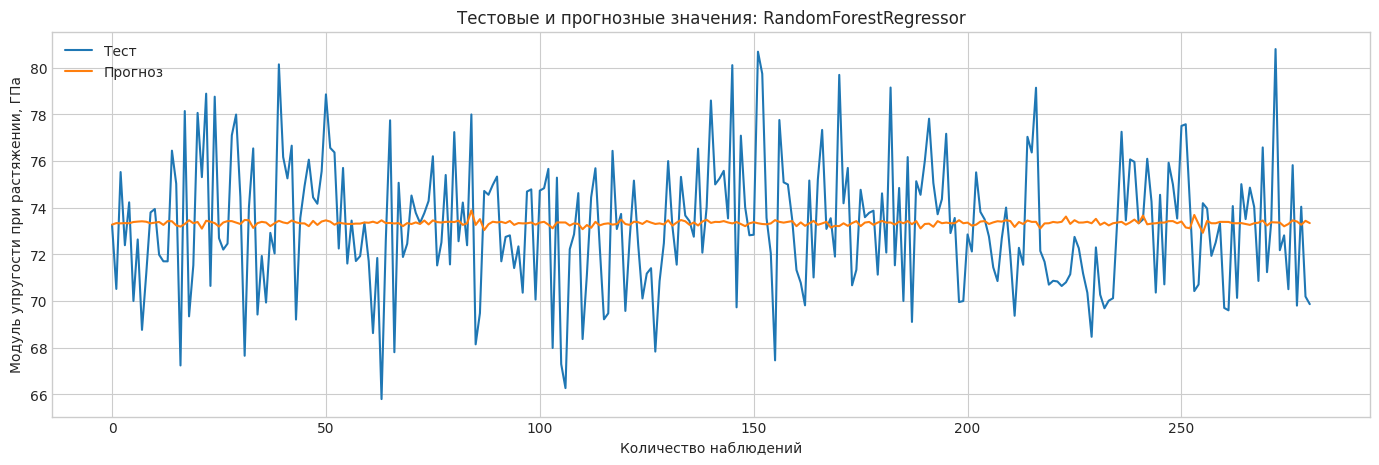

In [220]:
actual_and_predicted_plot(y_test.values, regr_rf_1.predict(X_test), 'Модуль упругости при растяжении, ГПа', 'RandomForestRegressor')

#### Многослойный перцептрон

In [229]:


# neuronet = MLPRegressor(random_state=0)
# neuronet_params = {
#     'hidden_layer_sizes' : [(12, 192, 48, 1),  (12, 12, 1), ],
#     'activation' : ['tanh', 'relu'],
#     'solver' : ['sgd', 'adam'],
#     'max_iter' : [100],
# }

# GSCV_neuronet_1 = GridSearchCV(neuronet, neuronet_params, n_jobs=-1, cv=10, verbose=0)
# GSCV_neuronet_1.fit(Xtrain, ytrain)
# GSCV_neuronet_1.best_params_
# neuronet_1 = GSCV_neuronet_1.best_estimator_

# MSE_1 = mean_squared_error(y_test, neuronet_1.predict(X_test))
# R2_1 = r2_score(y_test, neuronet_1.predict(X_test))

# neuronet_errors = pd.DataFrame({'model_name':'MLPRegressor',\
#                                 'target_var':['Модуль упругости при растяжении, ГПа'],\
#                                'MSE':[MSE_1, ],\
#                                'R2':[R2_1, ]})
# df_errors = pd.concat([df_errors, neuronet_errors], ignore_index=True)
# df_errors

/home/kotik/code/py/.venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kotik/code/py/.venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kotik/code/py/.venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kotik/code/py/.venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kotik/code/py/.venv/li

{'activation': 'tanh',
 'hidden_layer_sizes': (12, 12, 1),
 'max_iter': 100,
 'solver': 'sgd'}

In [222]:
# GSCV_neuronet_1.best_params_

In [223]:
# actual_and_predicted_plot(y_test.values, neuronet_1.predict(X_test), 'Модуль упругости при растяжении, ГПа', 'MLPRegressor')

#### Лассо регрессия

In [224]:
lasso = Lasso(random_state=0)
lasso_params = {
   'alpha': np.linspace(0, 1, 100)
}
GSCV_lasso_1 = GridSearchCV(lasso, lasso_params, cv=10, verbose=1)
GSCV_lasso_1.fit(Xtrain, ytrain)
# GSCV_lasso_1.best_params_ 

lasso_1 = GSCV_lasso_1.best_estimator_

MSE_1 = mean_squared_error(y_test, lasso_1.predict(X_test))
R2_1 = r2_score(y_test, lasso_1.predict(X_test))

lasso_errors = pd.DataFrame({'model_name':'Lasso1_grid_search',\
            'target_var':['Модуль упругости при растяжении, ГПа', ],\
            'MSE':[MSE_1, ],\
            'R2':[R2_1, ]})
df_errors = pd.concat([df_errors, lasso_errors], ignore_index=True)
df_errors

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


,target_var,model_name,MSE,R2
0,"Модуль упругости при растяжении, ГПа",LinearRegression_1,7.920709,-0.021947
1,"Модуль упругости при растяжении, ГПа",KNeighborsRegressor_1,7.797827,-0.006093
2,"Модуль упругости при растяжении, ГПа",RandomForestRegressor_1,8.114218,-0.046914
3,"Модуль упругости при растяжении, ГПа",RandomForestRegressor_1_grid_search,7.750835,-0.000030
4,"Модуль упругости при растяжении, ГПа",Lasso1_grid_search,7.967389,-0.027970


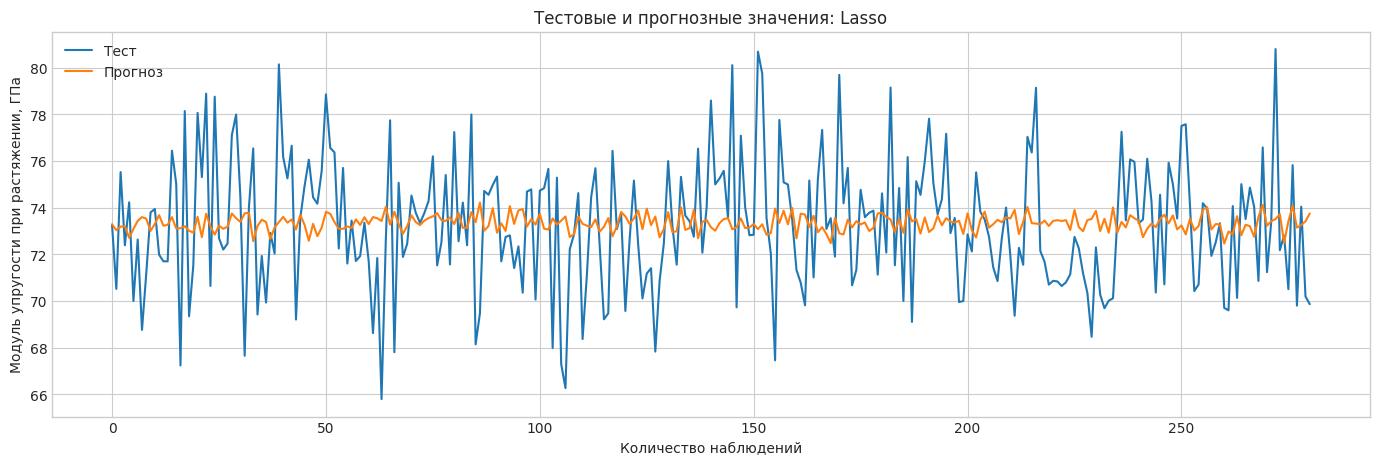

In [225]:
actual_and_predicted_plot(y_test.values, lasso_1.predict(X_test), 'Модуль упругости при растяжении, ГПа', 'Lasso')

## Итоговый датасет с ошибками

In [226]:
df_errors

,target_var,model_name,MSE,R2
0,"Модуль упругости при растяжении, ГПа",LinearRegression_1,7.920709,-0.021947
1,"Модуль упругости при растяжении, ГПа",KNeighborsRegressor_1,7.797827,-0.006093
2,"Модуль упругости при растяжении, ГПа",RandomForestRegressor_1,8.114218,-0.046914
3,"Модуль упругости при растяжении, ГПа",RandomForestRegressor_1_grid_search,7.750835,-0.000030
4,"Модуль упругости при растяжении, ГПа",Lasso1_grid_search,7.967389,-0.027970


#### Алгоритм полиномиальной регрессии

In [227]:
pipe = make_pipeline(PowerTransformer(), RobustScaler(), PolynomialFeatures(), Ridge(), )

param_grid = {
    'polynomialfeatures__degree': [1, 2, 3, 4, 5],
    'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]
    }

grid = GridSearchCV(pipe, param_grid, cv=10, n_jobs=-1)

grid.fit(Xtrain, ytrain)
print("Лучшая модель:\n{}".format(grid.best_estimator_))

mean_squared_error(y_test, grid.predict(X_test)), r2_score(y_test, grid.predict(X_test))



Лучшая модель:
Pipeline(steps=[('powertransformer', PowerTransformer()),
                ('robustscaler', RobustScaler()),
                ('polynomialfeatures', PolynomialFeatures(degree=1)),
                ('ridge', Ridge(alpha=100))])


(7.84943607862376, -0.012751564982365515)

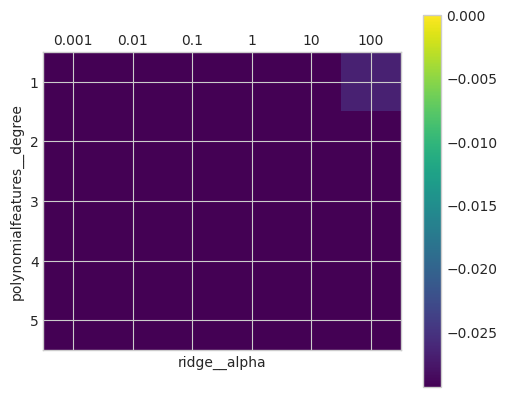

In [228]:
# Теплокарта для усредненной правильности перекрестной проверки,
# выраженной в виде функции двух параметров: параметра degree для
# полиномиального преобразования и параметра alpha для гребневой регрессии

plt.matshow(grid.cv_results_['mean_test_score'].reshape(len(param_grid['polynomialfeatures__degree']), -1), vmin=0, cmap="viridis")
plt.xlabel("ridge__alpha")
plt.ylabel("polynomialfeatures__degree")
plt.xticks(range(len(param_grid['ridge__alpha'])), param_grid['ridge__alpha'])
plt.yticks(range(len(param_grid['polynomialfeatures__degree'])),
param_grid['polynomialfeatures__degree'])
plt.colorbar()